In [1]:
import cv2

In [2]:
cv2.TrackerBoosting_create()

<TrackerBoosting 00000222679E42F0>

In [3]:
import cv2
import numpy as np
import math
import typing
import os
def show(frame):
    cv2.imshow("test", frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
def plot_point(frame,x,y,color=(0,255,0),radius = 0):
    thickness = -1
    return cv2.circle(frame, (x,y), radius, color, thickness)
def plot_line(frame,p1,p2,color=(0,191,255)):
    thickness = 2
    return cv2.line(frame, (p1[0],p1[1]), (p2[0],p2[1]), color, thickness)
def getIdealPointGroup(points):
  pointGroups = []
  index = 0
  subgroup = [points[0]]

  for i in range(len(points) - 1):
    prevPoint = points[i]
    currentPoint = points[i+1]

    if (abs(int(prevPoint[0])-int(currentPoint[0])) <= 1) and (abs(int(prevPoint[1])-int(currentPoint[1])) <= 1):
      subgroup.append(currentPoint)
    else:
      pointGroups.append(subgroup[:])
      subgroup = [currentPoint]

  pointGroups.append(subgroup)

  mainPointGroup = []
  maxPointGroupSize = 0

  for group in pointGroups:
    if len(group) > maxPointGroupSize:
      maxPointGroup = group
      maxPointGroupSize = len(group)

  return maxPointGroup

# Gets all the contours for certain image
  

def get_bottom_left(points,img,index = None):
  if not index is None:
    i = int(index*len(points))
    return points[i], index 
  max_y = len(img[0])
  index = 0
  dist = 100000
  count = 0
  for i in points:
    if (i[0])**2+(max_y-i[1])**2<dist:
      index = count
      dist = (i[0])**2+(max_y-i[1])**2
    count+=1
  return points[index],index/len(points)

def loadvideo(filename: str) -> np.ndarray:
    """Loads a video from a file.

    Args:
        filename (str): filename of video

    Returns:
        A np.ndarray with dimensions (channels=3, frames, height, width). The
        values will be uint8's ranging from 0 to 255.

    Raises:
        FileNotFoundError: Could not find `filename`
        ValueError: An error occurred while reading the video
    """

    if not os.path.exists(filename):
        raise FileNotFoundError(filename)
    capture = cv2.VideoCapture(filename)

    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

    v = np.zeros((frame_count, frame_height, frame_width, 3), np.uint8)

    for count in range(frame_count):
        ret, frame = capture.read()
        if not ret:
            raise ValueError("Failed to load frame #{} of {}.".format(count, filename))

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        v[count] = frame

    v = v.transpose((3, 0, 1, 2))

    return v
def savevideo(filename: str, array: np.ndarray, fps: typing.Union[float, int] = 1):
    """Saves a video to a file.

    Args:
        filename (str): filename of video
        array (np.ndarray): video of uint8's with shape (channels=3, frames, height, width)
        fps (float or int): frames per second

    Returns:
        None
    """

    c, f, height, width = array.shape

    if c != 3:
        raise ValueError("savevideo expects array of shape (channels=3, frames, height, width), got shape ({})".format(", ".join(map(str, array.shape))))
    fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
    out = cv2.VideoWriter(filename, fourcc, fps, (width, height))

    for i in range(f):
        out.write(array[:, i, :, :].transpose((1, 2, 0)))

        
def obtainContourPoints(img):
  # read image

  rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # set lower and upper bounds on blue color
  lower = (200,0,0)
  upper = (255,200,200)

  # threshold and invert so hexagon is white on black background
  thresh = cv2.inRange(rgb, lower, upper)
  #show(thresh)
  # get contours
  result = np.zeros_like(thresh)
  im2, contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  #print(im2,contours)
  cv2.drawContours(img, im2, -1, (0,255,0), 3)

  im2 = np.array(im2)
  index_1 = 0
  index_2 = 0
  for i in im2:
    if i.shape[0]>im2[index_1].shape[0]:
      index_1=index_2
    index_2+=1
  rec = cv2.minAreaRect(im2[index_1])
  color = (0, 0, 255) 
  thickness = 2
  box = cv2.boxPoints(rec)
  box = np.int0(box)
  indexes = [0,1]
  for i in range(0,len(box)):
    for k in range(0,len(indexes)):
      if box[i][1]>box[indexes[k]][1] and not i in indexes:
        indexes[k]=i

  #cv2.drawContours(img,[box],0,(191,0,255),2)
  #img = plot_line(img,box[indexes[0]],box[indexes[1]])
  #img = plot_point(img,box[indexes[0],0],box[indexes[0],1])
  #img = plot_point(img,box[indexes[1],0],box[indexes[1],1])
  #cv2.rectangle(img,rec,color,thickness)
  return img, [box[indexes[0]].tolist(),box[indexes[1]].tolist()]

In [4]:
import cv2
import numpy as np
# https://gist.github.com/epiception/ac8195435976f6d2356869589b7157de
'''KALMAN FILTERING CLASS FOR N 2D POINTS'''
'''Kalman filtering for selected points in an image using OpenCV cv2.kalmanFilter class in Python '''
class Kalman_Filtering:

    def __init__(self,n_points):
        self.n_points = n_points

    def initialize(self):

        n_states = self.n_points * 4
        n_measures = self.n_points * 2
        self.kalman = cv2.KalmanFilter(n_states,n_measures)
        # print(self.kalman)
        kalman = self.kalman
        kalman.transitionMatrix = np.eye(n_states, dtype = np.float32)
        #kalman.processNoiseCov = np.eye(n_states, dtype = np.float32)*0.9
        kalman.measurementNoiseCov = np.eye(n_measures, dtype = np.float32)*0.0005

        kalman.measurementMatrix = np.zeros((n_measures,n_states), np.float32)
        dt = 1

        self.Measurement_array = []
        self.dt_array = []

        for i in range(0,n_states,4):
            self.Measurement_array.append(i)
            self.Measurement_array.append(i+1)

        for i in range(0,n_states):
            if i not in self.Measurement_array:
                self.dt_array.append(i)

        # print(self.dt_array)
        # print(self.Measurement_array)
        #Transition Matrix for [x,y,x',y'] for n such points
        # format of first row [1 0 dt 0 .....]
        for i, j in zip(self.Measurement_array, self.dt_array):
            kalman.transitionMatrix[i,j] = dt;

        #Measurement Matrix for [x,y,x',y'] for n such points
        # format of first row [1 0 0 0 .....]
        for i in range(0,n_measures):
            kalman.measurementMatrix[i,self.Measurement_array[i]] = 1


        #print('TRANSITION Matrix:')
        #print(kalman.transitionMatrix)

        #print('MEASUREMENT Matrix:')
        #print(kalman.measurementMatrix)



    def predict(self,points):

        pred = []
        input_points = np.float32(np.ndarray.flatten(points))
        #Correction Step
        # print(input_points)
        self.kalman.correct(input_points)
        #Prediction step
        tp = self.kalman.predict()

        for i in self.Measurement_array:
            pred.append(int(tp[i]))

        return pred
def show(frame):
    cv2.imshow("test", frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
def load(vid):
    vid = loadvideo(vid)
    #vid = np.transpose(vid,(1,2,3,0))
    vid = vid[:,:,:,:112]
    return vid

In [5]:
def midpoint(point1,point2):
    return (point1+point2)/2
def change(points):
    point_arr = [points[0]]
    for i in points[1:]:
        point_arr.append(midpoint(point_arr[-1],i))
    return np.array(point_arr)
import matplotlib.pyplot as plt
def delta(points):
    point_arr = [points[0]]
    for i in points[1:]:
        if np.linalg.norm(i-point_arr[-1])<2:
            point_arr.append(point_arr[-1])
        else:
            point_arr.append(i)
    return np.array(point_arr)
    #plt.hist(point_arr,bins=50)
    #plt.show()
    #for i in range(1,len(points)):
    #    print(np.linalg.norm(points[i]-points[i-1]))

In [6]:
key_points = []
import pandas as pd
df = pd.read_csv('C:\\Users\TheurerJ\\Documents\\John\\dynamic\\echonet_segmentation_analysis\\Smoothed_Bottom_Points.csv')
unsmoothed_df = pd.read_csv('C:\\Users\TheurerJ\\Documents\\John\\dynamic\\echonet_segmentation_analysis\\Unsmoothed.csv')
from tqdm import tqdm
folder = 'C:\\Users\\TheurerJ\\Documents\\Data\\segmented'
output = 'C:\\Users\\TheurerJ\\Documents\\John\\dynamic\\echonet_segmentation_analysis\\Strain_5_Fixed_2'
numpy = 'Dilation_5_new'
filenames = []
frame_num = []
x1s = []
y1s = []
error1 = []
x2s = []
y2s = []
error2 = []
length = []
angle = []
key_frames = []
for i in tqdm(range(15,len(df['FileNames'].unique()))):
    vid = df['FileNames'].unique()[i]
    shortcut = df[df.FileNames==vid]
    old_shortcut = unsmoothed_df[unsmoothed_df.FileNames==vid]
    # print(vid)
    video_file = os.path.join(folder,vid)
    first = load(video_file)
    spare = first.copy()
    first = np.transpose(first,(1,2,3,0))
    thresh = np.load(os.path.join(numpy,vid[:-4]+'.npy'))
    #print(first.shape,thresh.shape)
    for frame in range(0,len(first)):
        rgb = cv2.cvtColor(first[frame,:,:], cv2.COLOR_BGR2RGB)
        t = (thresh[frame,:,:]*255).copy()
        t = cv2.inRange(t, 250, 255)
        # print(t.shape,np.min(t),np.max(t),type(t))
        # show(t)
        im2, contours = cv2.findContours(t, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # print(shortcut,frame,shortcut.index[frame])
        # cv2.drawContours(first[frame], im2, -1, (0,255,0), 3)
        x1 = int(shortcut['X1'][shortcut.index[frame]])
        y1 = int(shortcut['Y1'][shortcut.index[frame]])
        x2 = int(shortcut['X2'][shortcut.index[frame]])
        y2 = int(shortcut['Y2'][shortcut.index[frame]])
        def calc_degrees(point):
            return math.atan2(point[1], point[0])
        deg = calc_degrees([x1-x2,y1-y2])
        angle.append(deg)
        final_point = im2[0][0][0]
        index = 0
        count = 0
        for j in im2[0]:
            count+=1
            if np.linalg.norm(j[0]-np.array([x1,y1]))< np.linalg.norm(final_point-np.array([x1,y1])):
                final_point = j[0]
                index = count
        # print(final_point,np.array([x1,y1]), np.linalg.norm(final_point-np.array([x1,y1])),index)
        
        final_point2 = im2[0][0][0]
        index2 = 0
        count2 = 0
        for j in im2[0]:
            count2+=1
            if np.linalg.norm(j[0]-np.array([x2,y2]))< np.linalg.norm(final_point2-np.array([x2,y2])):
                final_point2 = j[0]
                index2 = count2
        # print(final_point2,np.array([x2,y2]), np.linalg.norm(final_point2-np.array([x2,y2])),index2)
        # plot_point(first[frame],x1,y1,color=(255,0,0))
        # plot_point(first[frame],x2,y2,color=(255,0,0))
        # print(im2)
        for k in range(0,index):
            plot_point(first[frame],im2[0][k][0][0],im2[0][k][0][1])
        for k in range(index2,len(im2[0])):
            plot_point(first[frame],im2[0][k][0][0],im2[0][k][0][1])
        for k in range(index,index2):
            plot_point(first[frame],im2[0][k][0][0],im2[0][k][0][1],color=(0,191,255))
        plot_point(first[frame],x1,y1,color=(255,0,255),radius=1)
        plot_point(first[frame],x2,y2,color=(255,0,255),radius=1)
        old_x1 = int(old_shortcut['X1'][old_shortcut.index[frame]])
        old_y1 = int(old_shortcut['Y1'][old_shortcut.index[frame]])
        old_x2 = int(old_shortcut['X2'][old_shortcut.index[frame]])
        old_y2 = int(old_shortcut['Y2'][old_shortcut.index[frame]])
        plot_point(first[frame],old_x1,old_y1,color=(0,255,0),radius=1)
        plot_point(first[frame],old_x2,old_y2,color=(0,255,0),radius=1)

        filenames.append(vid)
        frame_num.append(frame)
        x1s.append(final_point[0])
        y1s.append(final_point[1])
        error1.append(np.linalg.norm(final_point-np.array([x1,y1])))
        x2s.append(final_point2[0])
        y2s.append(final_point2[1])
        error2.append(np.linalg.norm(final_point2-np.array([x2,y2])))
        length.append(len(im2[0])-index2+index)
        #show(first[frame])


    video = np.transpose(np.array(first),(3,0,1,2))

    savevideo(os.path.join(output,vid),video,fps=30)
    """video = []
    guess = None
    vertexes = []
    for frame in range(0,len(first)):
        #print(temp.Frame==frame,frame)
        img,points = obtainContourPoints(first[frame])
        if exists and len(temp[temp.Frame ==frame]) == 1:

            delta_x1.append(points[0][0]-temp[temp.Frame ==frame].X1.tolist()[0])
            delta_y1.append(points[0][1]-temp[temp.Frame ==frame].Y1.tolist()[0])
            delta_x2.append(points[1][0]-temp[temp.Frame ==frame].X2.tolist()[0])
            delta_y2.append(points[1][1]-temp[temp.Frame ==frame].Y2.tolist()[0])
        vertexes.append(points)            
        # video.append(img)
        #show(img)"""


100%|████████████████████████████████████████████████████████████████████████████| 3198/3198 [1:10:59<00:00,  1.33s/it]


In [7]:
df

,Unnamed: 0,FileNames,Frame,X1,Y1,X2,Y2
0,0,0X100009310A3BD7FC.avi,0,50,70,76,67
1,1,0X100009310A3BD7FC.avi,1,50,69,76,67
2,2,0X100009310A3BD7FC.avi,2,50,69,76,67
3,3,0X100009310A3BD7FC.avi,3,51,69,76,67
4,4,0X100009310A3BD7FC.avi,4,50,68,75,67
...,...,...,...,...,...,...,...
568652,568652,0X36D558075BB74018.avi,192,43,70,73,65
568653,568653,0X36D558075BB74018.avi,193,43,70,73,65
568654,568654,0X36D558075BB74018.avi,194,43,70,73,65
568655,568655,0X36D558075BB74018.avi,195,42,70,73,66


In [8]:
unsmoothed_df

,Unnamed: 0,FileNames,Frame,X1,Y1,X2,Y2
0,0,0X100009310A3BD7FC.avi,0,50,70,76,67
1,1,0X100009310A3BD7FC.avi,1,50,69,76,67
2,2,0X100009310A3BD7FC.avi,2,50,69,76,68
3,3,0X100009310A3BD7FC.avi,3,52,69,76,67
4,4,0X100009310A3BD7FC.avi,4,50,67,75,67
...,...,...,...,...,...,...,...
568652,568652,0X36D558075BB74018.avi,192,44,71,73,66
568653,568653,0X36D558075BB74018.avi,193,44,71,73,66
568654,568654,0X36D558075BB74018.avi,194,44,70,73,65
568655,568655,0X36D558075BB74018.avi,195,42,70,74,67


In [9]:
final = pd.DataFrame({"filenames":filenames,'frame_num':frame_num,'x1':x1s,'y1':y1s,'error_1':error1,'x2':x2s,'y2':y2s,'error_2':error2,'length':length,'angle':angle})

100%|██████████████████████████████████████████████████████████████████████████████| 3198/3198 [10:21<00:00,  5.14it/s]


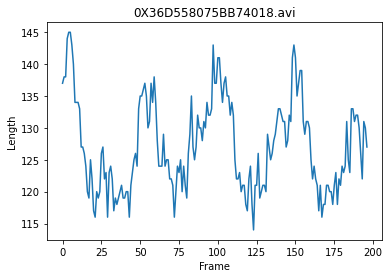

In [10]:
import matplotlib.pyplot as plt
for i in tqdm(final.filenames.unique()):
    plt.clf()
    plt.plot(final[final.filenames==i].frame_num,final[final.filenames==i].length)
    plt.xlabel("Frame")
    plt.ylabel("Length")
    plt.title(i)
    plt.savefig(os.path.join('strain_plot',i[:-4]+".png"))


In [11]:
final.to_csv("Strain_5.csv")

In [12]:
final.head()

,filenames,frame_num,x1,y1,error_1,x2,y2,error_2,length,angle
0,0X101E654AF3FC07A8.avi,0,46,61,4.000000,75,63,2.0,112,3.141593
1,0X101E654AF3FC07A8.avi,1,50,63,2.000000,75,63,2.0,115,3.141593
2,0X101E654AF3FC07A8.avi,2,49,63,2.236068,74,63,2.0,116,3.141593
3,0X101E654AF3FC07A8.avi,3,48,62,2.236068,74,63,2.0,111,3.141593
4,0X101E654AF3FC07A8.avi,4,50,63,2.000000,73,63,2.0,116,3.141593


100%|██████████████████████████████████████████████████████████████████████████████| 3198/3198 [02:36<00:00, 20.46it/s]


(array([3.178e+03, 1.100e+01, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([  0.,  32.,  64.,  96., 128., 160., 192., 224., 256., 288., 320.]),
 <a list of 10 Patch objects>)

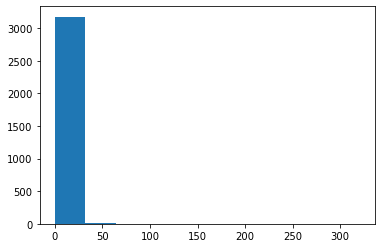

In [13]:
strain_ratio = []
angle_at_max = []
angle_at_min = []
for f in tqdm(final.filenames.unique()):
    max_index = final[final.filenames==f].length.idxmax()
    min_index = final[final.filenames==f].length.idxmin()
    angle_at_max.append(final.angle[max_index])
    angle_at_min.append(final.angle[min_index])
    if final.length[max_index]>0 and final.length[min_index]>0:
        strain_ratio.append(final.length[max_index]/final.length[min_index])
    else:
        strain_ratio.append(0)
plt.hist(strain_ratio)

(array([ 137.,   19.,   37.,   16.,   12.,   26.,   87.,  981., 1633.,
         246.]),
 array([0.003125  , 0.09559028, 0.18805556, 0.28052083, 0.37298611,
        0.46545139, 0.55791667, 0.65038194, 0.74284722, 0.8353125 ,
        0.92777778]),
 <a list of 10 Patch objects>)

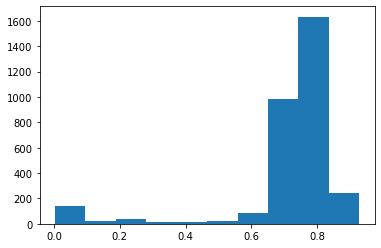

In [14]:
shortcut = np.array(strain_ratio)
shortcut = shortcut[shortcut>0]
plt.hist(1/np.array(shortcut))